# Hull-White Term Structure Simulations

這篇文章將介紹如何在 QuantLib Python 中模擬 Hull-White 利率期限結構模型。Hull-White 利率模型定義如下：

drt=(θ(t)−art)dt+σdWt

在這個公式中：

- r 是瞬時短期利率，這是我們關心的主要變量，它在時間 t 的變動量是 drt。
- θ(t) 是一個時間相關的參數，其目的是使得模型能夠更好地配合市場上觀察到的利率期限結構。換句話說，這個參數可以為模型提供足夠的彈性，使其能夠與任意給定的初始期限結構相吻合。
- a 是正的常數，描述了利率的均值回復速度，即利率如何向長期均值回歸的速度。如果 a 很大，利率將迅速回歸其長期均值；如果 a 很小，利率將緩慢回歸其長期均值。
- σ 是利率的波動率，描述了利率變化的不確定性或風險。這個參數在許多衍生品定價中都是非常重要的。
- Wt 是一個標準 Brownian motion，或稱為 Wiener process，是一種連續的隨機過程，主要用於模擬許多金融模型中的隨機行為。


Hull-White 模型主要被用於金融衍生品的定價，尤其是在利率衍生品（如選擇權、期貨和互換合約等）和固定收入產品中被廣泛使用。此外，由於模型的彈性和擬合能力，它也被用於風險管理和資產負債管理等領域。



In [3]:
import QuantLib as ql
import matplotlib.pyplot as plt
import numpy as np

# 定義 Hull-White 模型的常數
sigma = 0.1
a = 0.1
timestep = 360
length = 30 # 年
forward_rate = 0.05
day_count = ql.Thirty360(ql.Thirty360.ISDA)
todays_date = ql.Date(15, 1, 2015)
ql.Settings.instance().evaluationDate = todays_date


建立 Hull-White 過程，其中包含定義 Hull-White 模型的常數以及利率期限結構：

In [4]:
spot_curve = ql.FlatForward(todays_date, ql.QuoteHandle(ql.SimpleQuote(forward_rate)), day_count)
spot_curve_handle = ql.YieldTermStructureHandle(spot_curve)
hw_process = ql.HullWhiteProcess(spot_curve_handle, a, sigma)
rng = ql.GaussianRandomSequenceGenerator(ql.UniformRandomSequenceGenerator(timestep, ql.UniformRandomGenerator()))
seq = ql.GaussianPathGenerator(hw_process, length, timestep, rng, False)


寫一個函數來產生模擬的路徑：

In [5]:
def generate_paths(num_paths, timestep):
    arr = np.zeros((num_paths, timestep+1))
    for i in range(num_paths):
        sample_path = seq.next()
        path = sample_path.value()
        time = [path.time(j) for j in range(len(path))]
        value = [path[j] for j in range(len(path))]
        arr[i, :] = np.array(value)
    return np.array(time), arr


使用此函數，我們就可以模擬短期利率：

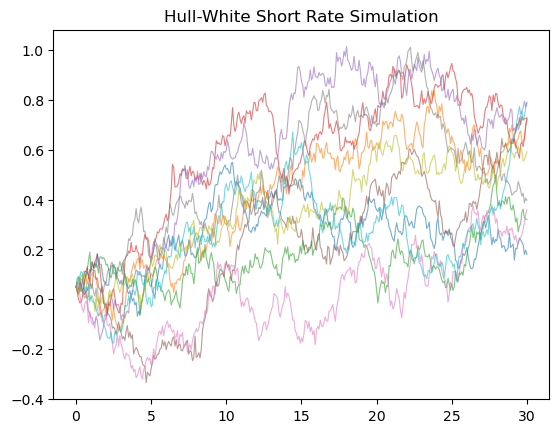

In [6]:
num_paths = 10
time, paths = generate_paths(num_paths, timestep)
for i in range(num_paths):
    plt.plot(time, paths[i, :], lw=0.8, alpha=0.6)
plt.title("Hull-White Short Rate Simulation")
plt.show()


將模擬的結果與理論上的數值進行比較：

Text(0.5, 1.0, 'Variance of Short Rates')

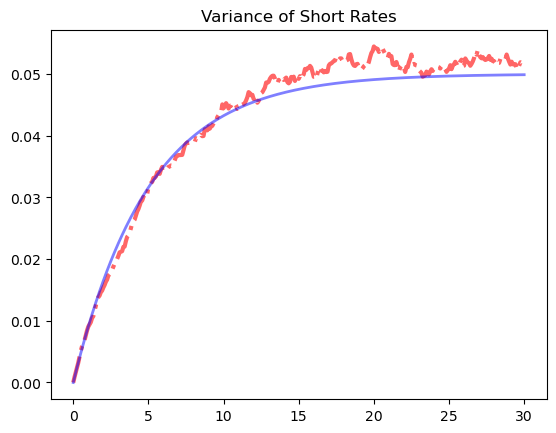

In [8]:
num_paths = 1000
time, paths = generate_paths(num_paths, timestep)

vol = [np.var(paths[:, i]) for i in range(timestep+1)]
plt.plot(time, vol, "r-.", lw=3, alpha=0.6)
plt.plot(time,sigma*sigma/(2*a)*(1.0-np.exp(-2.0*a*np.array(time))), "b-", lw=2, alpha=0.5)
plt.title("Variance of Short Rates")

Text(0.5, 1.0, 'Mean of Short Rates')

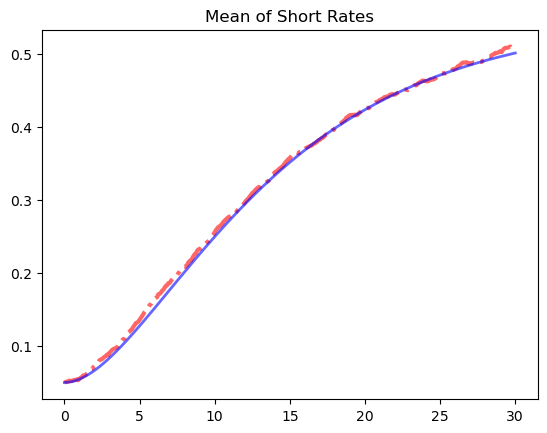

In [9]:
def alpha(forward, sigma, a, t):
    return forward + 0.5* np.power(sigma/a*(1.0 - np.exp(-a*t)), 2)

avg = [np.mean(paths[:, i]) for i in range(timestep+1)]
plt.plot(time, avg, "r-.", lw=3, alpha=0.6)
plt.plot(time,alpha(forward_rate, sigma, a, time), "b-", lw=2, alpha=0.6)
plt.title("Mean of Short Rates")

## 核心概念：

- Hull-White 利率模型：這是一種一因子模型，主要參數包括 a（瞬時利率的回復力度）、σ（利率的波動率）以及 θ(t)，其中 θ(t) 的選擇是為了擬合輸入的利率期限結構。描述的是短期利率的隨機過程。這種模型對於訂價衍生性金融商品是十分重要的。
- 模擬：模擬過程中主要使用了 GaussianPathGenerator 和 GaussianRandomSequenceGenerator 兩種隨機數生成器，並利用生成的隨機序列來模擬 Hull-White 短期利率模型的路徑。在模擬完成後，我們可以將模擬結果與理論值進行比較。這裡比較的是模擬結果的平均值和變異數與理論值的比較。從結果可以看出，模擬結果與理論值是非常接近的。

